# CenterNet model Inference using TensorFlow

The authors have provided the code on GitHub [6]. However, we will use TensorFlow Hub [7] to download the pre-trained CenterNet models and make inferences.

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import urllib

In [2]:
tf.__version__

'2.9.2'

## Select CenterNet Models
TensorFlow hub has the following CenterNet pre-trained model:

- ResNet18
- ResNet50
- ResNet101
- DLA-34
- Hourglass104


Here, we will use **ResNet101** and **Hourglass104** for inference.

In [3]:
models = {
          'Resnet101':'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',   
          'HourGlass104':'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1'
         }

## Download Images

Images URLS.

In [4]:
images = [
          'https://farm7.staticflickr.com/6073/6032446158_85fa667cd2_z.jpg',
          'https://farm9.staticflickr.com/8538/8678472399_886f8eabec_z.jpg',
          'https://farm6.staticflickr.com/5485/10028794463_d8cbb38932_z.jpg',
          'https://farm4.staticflickr.com/3057/2475401198_0a342a907e_z.jpg'
         ]

Download images.

In [5]:
# Download images.
for i in range(len(images)):
    urllib.request.urlretrieve(images[i], "img{}.jpg".format(i+1))

Read images.

In [6]:
# Read Images.
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')
img3 = cv2.imread('img3.jpg')
img4 = cv2.imread('img4.jpg')

Plot images.

In [7]:
def plot_images(img_list, title=None, row=1, column=2, 
                fig_size=(10, 15)):
    plt.figure(figsize=fig_size)
    for i, img in enumerate(img_list):
        plt.subplot(row, column, i+1)
        plt.imshow(img[...,::-1])
        plt.axis('off')
        plt.title(title[i] if title else 'img{}'.format(i+1))
    plt.show()

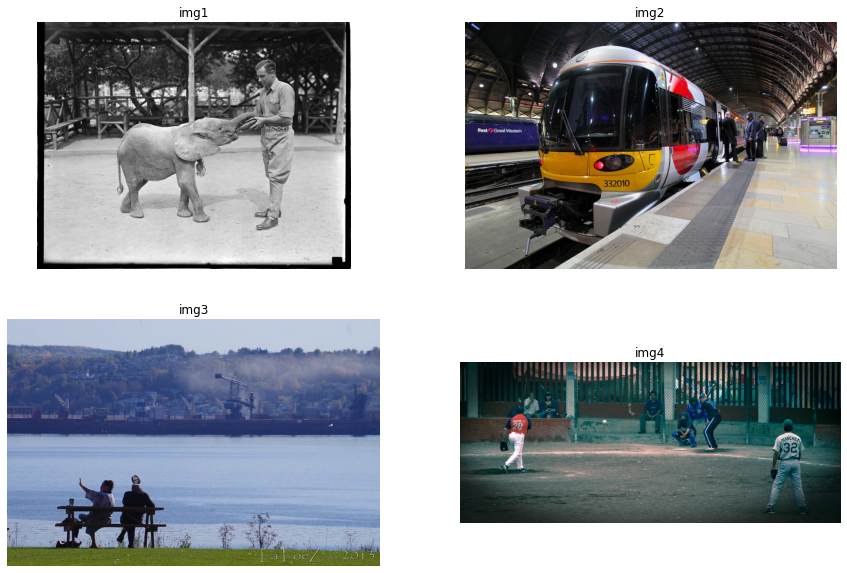

In [8]:
image_list = [img1, img2, img3, img4]
plot_images(image_list, row=2, column=2, fig_size=(15, 10))

## COCO Classes

TensorFlow models are trained on the COCO dataset. So we need the class name for the class id map.

In [9]:
category_index = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 
                  5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 
                  10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 
                  14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 
                  18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 
                  22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 
                  27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 
                  33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 
                  37: 'sports ball', 38: 'kite', 39: 'baseball bat', 
                  40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 
                  43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 
                  47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl',  
                  52: 'banana',  53: 'apple',  54: 'sandwich',  55: 'orange',  
                  56: 'broccoli',  57: 'carrot',  58: 'hot dog',  59: 'pizza',  
                  60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 
                  64: 'potted plant', 65: 'bed', 67: 'dining table', 
                  70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 
                  75: 'remote', 76: 'keyboard', 77: 'cell phone', 
                  78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 
                  82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 
                  87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 
                  90: 'toothbrush'}

## Class IDs to Color IDs

Let us create color IDs for each class so we can use them to plot bounding boxes of different classes with different colors. 

In [10]:
R = np.array(np.arange(0, 256, 63))
G = np.roll(R, 2)
B = np.roll(R, 4)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

## Load Model from TF Hub

To load the model from TF Hub, use the following code. 

```python
model = hub.load(<link_to_the_desired_model>)
```


In [ ]:
# ResNet101.
resnet = hub.load(models['Resnet101'])
# Hourglass104.
hourglass = hub.load(models['HourGlass104'])

## Run Inference

An inference outcome is a dictionary with the following keys:
 
 - Number of detections
 - Detection boxes
 - Detection scores
 - Detection classes
 
 Let's make an inference. 

In [12]:
# Hourglass104 inference.
result_hourglass = hourglass(np.array([img1]))                  

Let's print the keys of the predicted dictionary. 

In [13]:
result_hourglass.keys()

dict_keys(['detection_classes', 'detection_scores', 'num_detections', 'detection_boxes'])

Let's check the shapes of the prediction. 

In [14]:
print('num_detections shape\t:{}'.format(result_hourglass['num_detections'].shape))
print('detection_boxes shape\t:{}'.format(result_hourglass['detection_boxes'].shape))
print('detection_scores shape\t:{}'.format(result_hourglass['detection_scores'].shape))
print('detection_classes shape\t:{}'.format(result_hourglass['detection_classes'].shape))

num_detections shape	:(1,)
detection_boxes shape	:(1, 100, 4)
detection_scores shape	:(1, 100)
detection_classes shape	:(1, 100)


You can see that the total number of bounding boxes is 100. 

Let's write a function to convert the TF tensor to NumPy. The function takes the model prediction and returns boxes, scores, and classes. 

In [15]:
def to_numpy(prediction):
    result = dict()
    bboxes = prediction['detection_boxes'][0].numpy()
    scores = prediction['detection_scores'][0].numpy()
    # class ids are int
    classes = prediction['detection_classes'][0].numpy().astype(int)
    return bboxes, scores, classes


In [16]:
print_count = 5
bboxes, scores, classes = to_numpy(result_hourglass)
print('detection_boxes:\n{}'.format(bboxes[:print_count]))
print('detection_scores:\n{}'.format(scores[:print_count]))
print('detection_classes:\n{}'.format(classes[:print_count]))

detection_boxes:
[[0.36475214 0.2544147  0.8116531  0.7097043 ]
 [0.15214191 0.6827493  0.84660524 0.82337785]
 [0.30334035 0.85521215 0.4586329  0.94833416]
 [0.36117637 0.19265035 0.48011312 0.2846129 ]
 [0.390655   0.6316224  0.4466164  0.7015844 ]]
detection_scores:
[0.95722336 0.9190534  0.575393   0.48818225 0.46633196]
detection_classes:
[22  1 62 15 44]


Let's write a function to filter confident predictions. 

In [17]:
def filter_detections_on_score(boxes, scores, classes, score_thresh=0.3):
    ids = np.where(scores >= score_thresh)
    return boxes[ids], scores[ids], classes[ids]

In [18]:
score_thresh = 0.30
bboxes, scores, classes = filter_detections_on_score(bboxes, scores, classes, 
                                                    score_thresh)
print('detection_boxes:\n{}'.format(bboxes))
print('detection_scores:\n{}'.format(scores))
print('detection_classes:\n{}'.format(classes))

detection_boxes:
[[0.36475214 0.2544147  0.8116531  0.7097043 ]
 [0.15214191 0.6827493  0.84660524 0.82337785]
 [0.30334035 0.85521215 0.4586329  0.94833416]
 [0.36117637 0.19265035 0.48011312 0.2846129 ]
 [0.390655   0.6316224  0.4466164  0.7015844 ]
 [0.3120035  0.02235281 0.52857524 0.1586653 ]
 [0.3826255  0.02449112 0.49790186 0.15688817]
 [0.2699546  0.7290414  0.30082417 0.75153786]]
detection_scores:
[0.95722336 0.9190534  0.575393   0.48818225 0.46633196 0.36656532
 0.36645815 0.31047532]
detection_classes:
[22  1 62 15 44 15 15 32]


You can see that the bounding box coordinates are in normalized form. So let's write a function to convert it into pixel form. 

In [19]:
def normalize_to_pixels_bboxs(bboxes, img):
    img_height, img_width, _ = img.shape
    bboxes[:, 0] *= img_height
    bboxes[:, 1] *= img_width
    bboxes[:, 2] *= img_height
    bboxes[:, 3] *= img_width
    return bboxes.astype(int)

In [20]:
bboxes = normalize_to_pixels_bboxs(bboxes, img1)
print('detection_boxes:\n{}'.format(bboxes))

detection_boxes:
[[184 162 409 454]
 [ 76 436 427 526]
 [153 547 231 606]
 [182 123 242 182]
 [197 404 225 449]
 [157  14 266 101]
 [193  15 251 100]
 [136 466 151 480]]


Let's write a function to annotate detection into the image.

In [21]:
def add_prediction_to_image(img, bboxes, scores, classes, id_class_map=category_index, colors=COLOR_IDS):
    img_with_bbox = img.copy()
    for box, score, cls in zip(bboxes, scores, classes):
        top, left, bottom, right = box
        class_name = id_class_map[cls]

        # Bounding box annotations.
        color = tuple(colors[cls % len(COLOR_IDS)].tolist())[::-1]
        img_with_bbox = cv2.rectangle(img_with_bbox, (left, top), (right, bottom), color, thickness=2)
        display_txt = '{}: {:.2f}'.format(class_name, score)
        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2) 
        img_with_bbox = cv2.rectangle(img_with_bbox, (left, top - int(0.9 * text_height)), (left + int(0.4*text_width), top), color, thickness=-1)
        img_with_bbox = cv2.putText(img_with_bbox, display_txt, (left, top - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

    return img_with_bbox


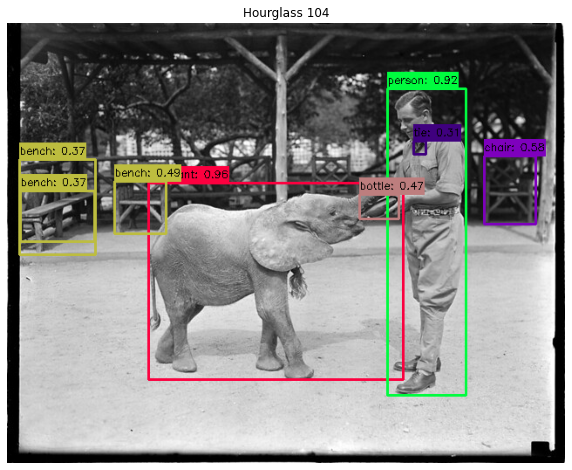

In [22]:
annotated_img = add_prediction_to_image(img1, bboxes, scores, classes)
plot_images([annotated_img], ['Hourglass 104'],row=1, column=1, fig_size=(10, 10))

It's time to put everything together.


Let's write a function that takes an image, a model, and a score threshold. And it makes an inference, filter bounding boxes, annotate bounding boxes to the image, and returns the annotated image.

In [23]:
def infer_and_add_prediction_to_image(img, model, score_thresh=0.3):
    prediction = model(np.array([img]))
    bboxes, scores, classes = to_numpy(prediction)

    bboxes, scores, classes = filter_detections_on_score(bboxes, scores, classes, 
                                                        score_thresh)
    boxes = normalize_to_pixels_bboxs(bboxes, img)
    img_with_bboxes = add_prediction_to_image(img, boxes, scores, classes)
    return img_with_bboxes

Let's use the above function with img1 and the ResNet model. 

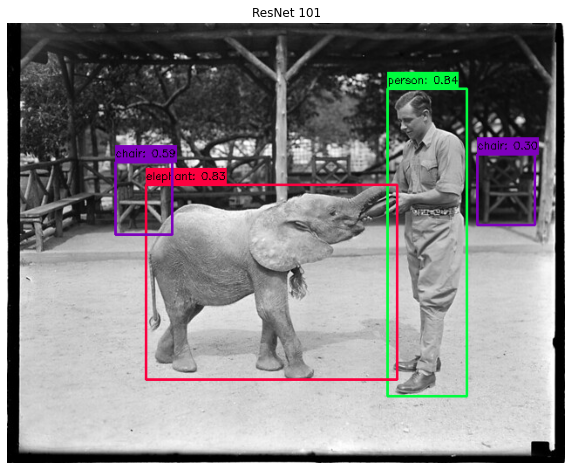

In [24]:
annotated_img = infer_and_add_prediction_to_image(img1, resnet)
plot_images([annotated_img], ['ResNet 101'], row=1, column=1, fig_size=(10, 10))

Let's write a wrapper function that takes an image, makes inferences on both Hourglass and ResNet models, and plots filtered detection.

In [25]:
def show_hourglass_resnet_inference(img, score_thresh=0.3):
    hourglass_infer = infer_and_add_prediction_to_image(img, hourglass)
    resnet_infer = infer_and_add_prediction_to_image(img, resnet)
    image_list = [hourglass_infer, resnet_infer]
    titles = ['Hourglass 104', 'ResNet 101']
    plot_images(image_list, titles, row=1, column=2, fig_size=(20, 10))


Let's use the above function for all four images one by one. 

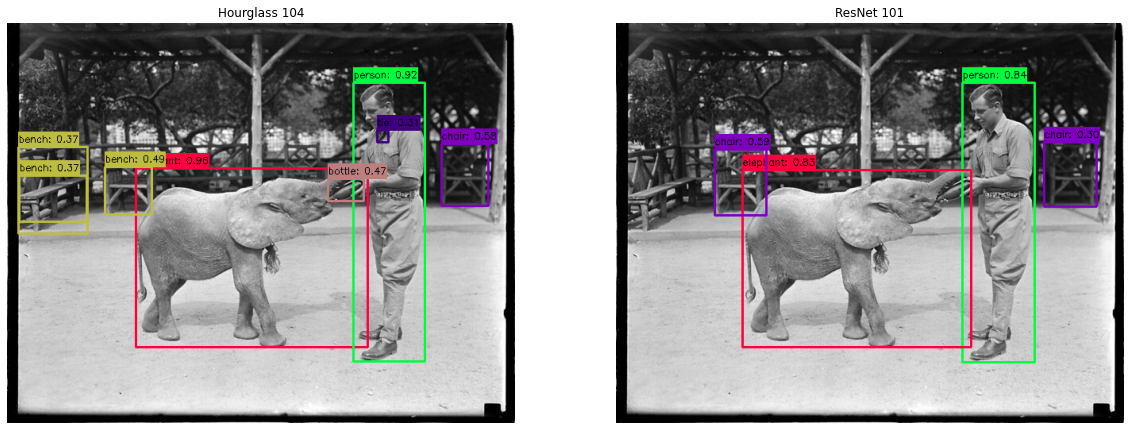

In [26]:
show_hourglass_resnet_inference(img1)

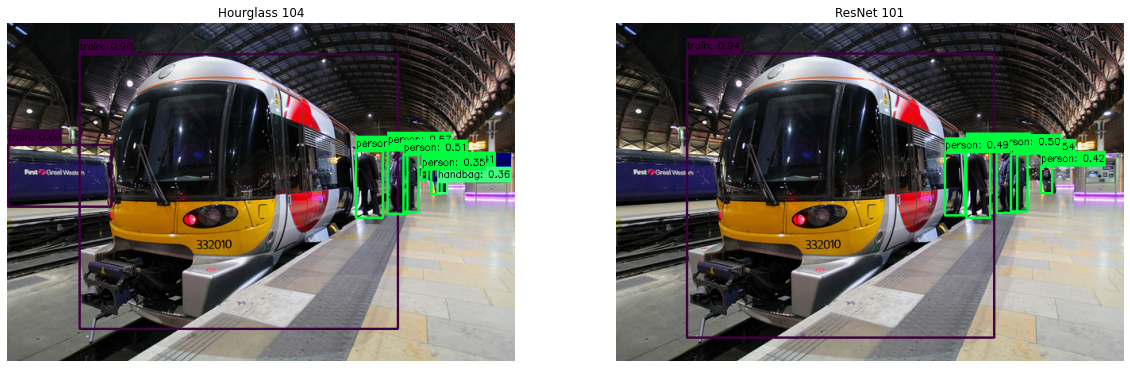

In [27]:
show_hourglass_resnet_inference(img2)

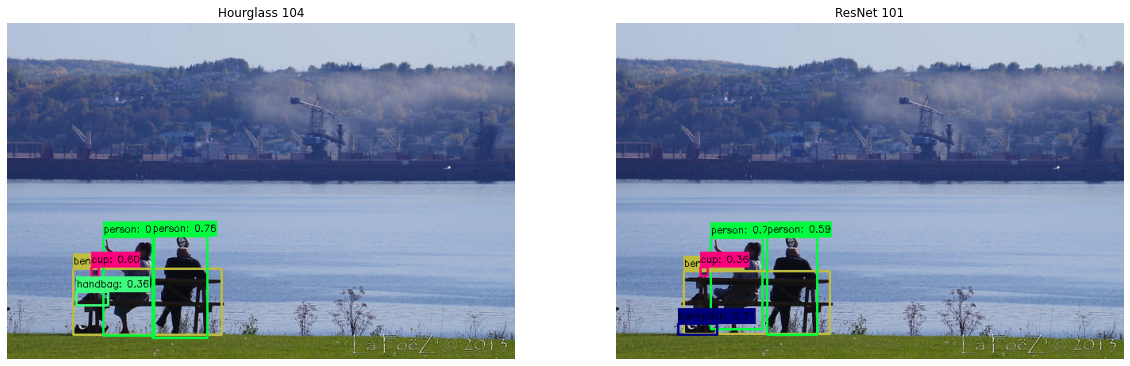

In [28]:
show_hourglass_resnet_inference(img3)

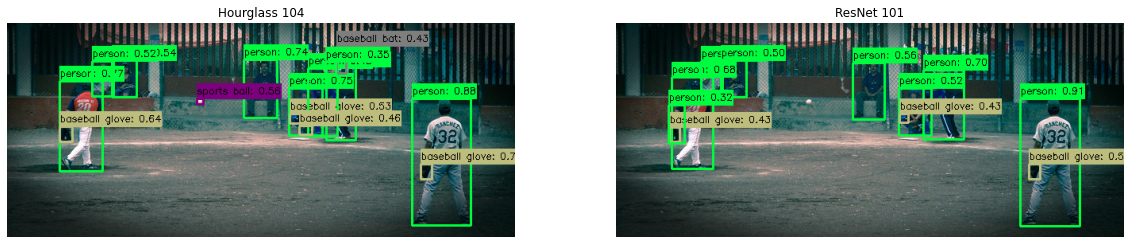

In [29]:
show_hourglass_resnet_inference(img4)

Here, you can notice that Hourglass 104 model is better than ResNet 101. 